# Universal differential equation for the SIR model

In this notebook, we want to jointly estimate the parameter $\gamma$ of the known part of the mechanistic model and the parameters $\theta$ of the neural network, which is supposed to learn the unknown residual dynamics.

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(1);

### Define the SIR dynamics and solve the ODE

In [2]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ODE = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0);

In [3]:
prob = ODEProblem(sir!, u0, tspan, p_ODE)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

### Add multiplicative log-normal noise

In [4]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.05)
noise = rand(rng, dist, size(X[:, begin:4:end]))
X_noisy = noise .* X[:, begin:4:end];

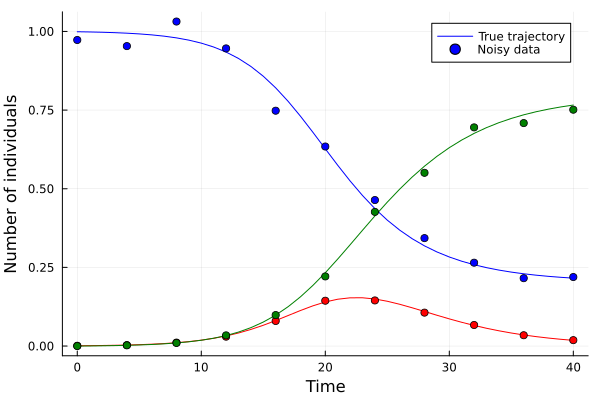

In [5]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals",
     color = [:blue :red :green], label = ["True trajectory" nothing nothing])
scatter!(t[begin:4:end], X_noisy', color = [:blue :red :green], label = ["Noisy data" nothing nothing])

### Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u, \gamma)+\text{NN}(u, \theta)$.

In [6]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))

# Multi-layer feed-forward neural network
model = Chain(Dense(3, 5, rbf), Dense(5, 5, rbf), Dense(5, 5, rbf), Dense(5, 3))

# Get initial parameters and state variables of the model
θ_init, st = Lux.setup(rng, model);

In [7]:
# Define the hybrid model
function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u, p.nn, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = -p.γ*u[2] + nn[2] 
    du[3] = p.γ*u[2] + nn[3]
end

γ_init = 0.1
p_init = (nn = θ_init, γ = γ_init)
p_init = ComponentVector(p_init)
prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### Set up the training

In [8]:
function predict(p, saveat = t[begin:4:end])   # p contains NN parameters θ and mechanistic parameter γ of the ODE
    _prob = remake(prob_ude, p = p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = saveat,
                sensealg = QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [9]:
function loss(p)
    X̂ = predict(p)
    mean(abs2, X_noisy .- X̂)   # MSE loss
end;

In [10]:
losses = Float64[]

function callback(p, l)
    push!(losses, l)
    n_iter = length(losses)
    if n_iter % 50 == 0   
        println("Loss after $(n_iter) iterations: $(losses[end])")
    end
    return false
end;

### Train the UDE

In [11]:
adtype = AutoZygote()   # automatic differentiation
optf = OptimizationFunction((p, _) -> loss(p), adtype)
optprob = OptimizationProblem(optf, p_init);

In [12]:
res1 = solve(optprob, ADAM(), callback = callback, maxiters = 5000);

Loss after 50 iterations: 458.2716935891981
Loss after 100 iterations: 161.70727486347047
Loss after 150 iterations: 65.54879020702387
Loss after 200 iterations: 34.407708499705514
Loss after 250 iterations: 19.851104871146436
Loss after 300 iterations: 12.06113705249561
Loss after 350 iterations: 7.662546953781837
Loss after 400 iterations: 5.073394155065496
Loss after 450 iterations: 3.4869344257512465
Loss after 500 iterations: 2.464415882501655
Loss after 550 iterations: 1.7642598721134752
Loss after 600 iterations: 1.2451241055716666
Loss after 650 iterations: 0.8277484521702703
Loss after 700 iterations: 0.5343774897420626
Loss after 750 iterations: 0.353474999915902
Loss after 800 iterations: 0.23526998422998893
Loss after 850 iterations: 0.1559926346078932
Loss after 900 iterations: 0.10515752997721446
Loss after 950 iterations: 0.07420577853731468
Loss after 1000 iterations: 0.05477153627507172
Loss after 1050 iterations: 0.04120194593729185
Loss after 1100 iterations: 0.03086

In [13]:
optprob2 = OptimizationProblem(optf, res1.u)
res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = 1500)
p_trained = res2.u;

Loss after 5050 iterations: 0.0009650462864311632
Loss after 5100 iterations: 0.0007334360077322123
Loss after 5150 iterations: 0.000561093767759379
Loss after 5200 iterations: 0.000531816265750227
Loss after 5250 iterations: 0.0005008568341204903
Loss after 5300 iterations: 0.00046986548790339957
Loss after 5350 iterations: 0.0004506932161478733
Loss after 5400 iterations: 0.0004480105028794822
Loss after 5450 iterations: 0.00044401240793284286
Loss after 5500 iterations: 0.0004391016371237451
Loss after 5550 iterations: 0.00043616459372423374
Loss after 5600 iterations: 0.00043485002706343187
Loss after 5650 iterations: 0.0004331617017712494
Loss after 5700 iterations: 0.0004282839662925872
Loss after 5750 iterations: 0.0004230282074481304
Loss after 5800 iterations: 0.00041939890956267266
Loss after 5850 iterations: 0.00041609309870349164
Loss after 5900 iterations: 0.00041433424432337336
Loss after 5950 iterations: 0.0004124998075964999
Loss after 6000 iterations: 0.000407664319212

### Visualize the results

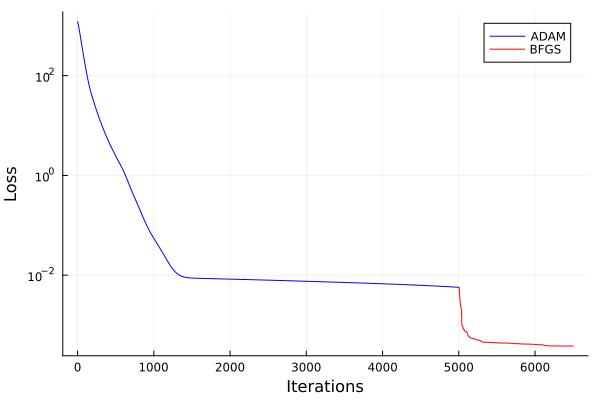

In [14]:
plot(1:5000, losses[1:5000], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM", color=:blue)
plot!(5001:length(losses), losses[5001:end], yaxis=:log10, label="BFGS", color=:red)

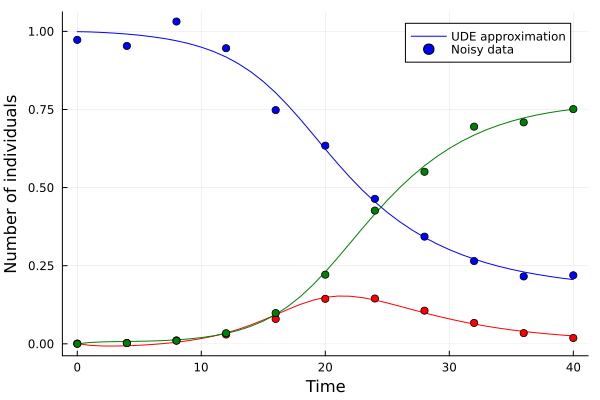

In [15]:
X̂ = predict(p_trained, t)
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :red :green],
     label = ["UDE approximation" nothing nothing])
scatter!(t[begin:4:end], X_noisy', color = [:blue :red :green], label = ["Noisy data" nothing nothing])

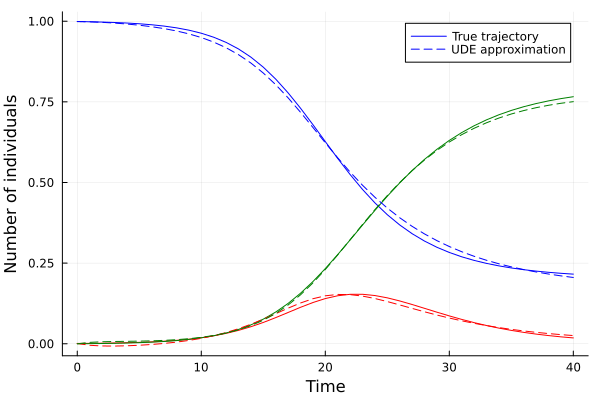

In [16]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals", color = [:blue :red :green], 
     label = ["True trajectory" nothing nothing])
plot!(t, X̂', linestyle = :dash, color = [:blue :red :green], label = ["UDE approximation" nothing nothing])

In [17]:
p_trained.γ

0.5314725114324588

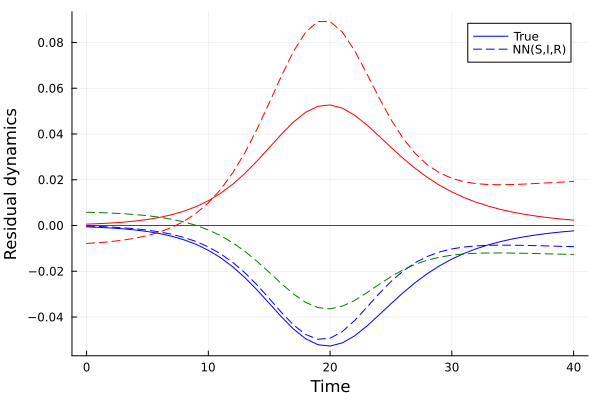

In [19]:
# True residual dynamics (i.e. interactions of predictors) along the true trajectory
dynamics_true = [-p_ODE[1]/p_ODE[3] * (X[1, :] .* X[2, :])'; p_ODE[1]/p_ODE[3] * (X[1, :] .* X[2, :])'; 
                 zeros(length(t))']
# Neural network guess along the true trajectory
dynamics_nn = Lux.apply(model, X, p_trained.nn, st)[1]

plot(t, dynamics_true', xlabel = "Time", ylabel = "Residual dynamics", color = [:blue :red :green], 
     label = ["True" nothing nothing])
plot!(t, dynamics_nn', color = [:blue :red :green], linestyle = :dash, label = ["NN(S,I,R)" nothing nothing])

The UDE recovers the true trajectory very well. However, the mechanistic parameter $\gamma$ is over-estimated, and the residual dynamics learned by the NN deviates considerably from the true ones (along the true trajectory). This implies that a part of the effect of the mechanistic model was absorbed by the NN, which is undesired.